In [1]:
# -*- coding: utf-8 -*-
from __future__ import print_function
from __future__ import division
import datetime

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import pandas as pd
import numpy as np

## Data import

### Importing observation data from SQLite database

In [19]:
import sqlite3
con = sqlite3.connect('../data/raw/__Phenology-Data__.sqlite')

In [20]:
query_template = """
SELECT '[VEGTYPE]' AS veg_type, '[EVENT]' AS event_type, o.observation_date AS event_date, o.species_id,
       s.species_sci_name, ss.species_family_name, ss.species_eng_name, ss.species_cat, ss.species_type,
       s.school_name, d.dzongkhag
FROM pw_[VEGTYPE]_observation_table AS o
LEFT JOIN pw_species_id_table AS s ON s.species_id=o.species_id
LEFT JOIN pw_species_table AS ss ON s.species_sci_name=ss.species_sci_name
LEFT JOIN pw_school_table AS sc ON s.school_name=sc.school_name
LEFT JOIN dzongkhag_table AS d ON d.bpn_dzongkhag_id=sc.dzongkhag_id
WHERE o.[EVENT]_img IS NOT ""
"""

In [21]:
vegtype_events = {
    'tree': ['bud_burst', 'young_leaf', 'flower_bud', 'flower', 'fruit', 'ripe_fruit', 'leaf_fall'],
    'shrub': ['bud_burst', 'young_leaf', 'flower_bud', 'flower', 'fruit', 'ripe_fruit', 'leaf_fall'],
    'tree_conifer': ['needle_bud', 'needle', 'seed_cone', 'ripe_seed_cone', 'needle_fall'],
    'herb': ['initial_growth', 'leaf', 'flower_bud', 'flower', 'fruit', 'ripe_fruit']
}

In [22]:
from pandas.io.sql import DatabaseError

dfo = pd.DataFrame()
for vegtype in vegtype_events.keys():
    for event in vegtype_events[vegtype]:
        query = query_template.replace('[VEGTYPE]', vegtype).replace('[EVENT]', event)
        print('Querying DB for %s/%s... ' % (vegtype, event), end='')
        try:
            dfq = pd.read_sql(query, con)
            print('OK (%d records)' % len(dfq))
            dfo = dfo.append(dfq)
        except DatabaseError as e:
            print('ERROR')

Querying DB for tree_conifer/needle_bud... OK (8 records)
Querying DB for tree_conifer/needle... OK (6 records)
Querying DB for tree_conifer/seed_cone... OK (8 records)
Querying DB for tree_conifer/ripe_seed_cone... OK (3 records)
Querying DB for tree_conifer/needle_fall... OK (1 records)
Querying DB for tree/bud_burst... OK (51 records)
Querying DB for tree/young_leaf... OK (57 records)
Querying DB for tree/flower_bud... OK (41 records)
Querying DB for tree/flower... OK (49 records)
Querying DB for tree/fruit... OK (48 records)
Querying DB for tree/ripe_fruit... OK (20 records)
Querying DB for tree/leaf_fall... OK (19 records)
Querying DB for shrub/bud_burst... OK (23 records)
Querying DB for shrub/young_leaf... OK (23 records)
Querying DB for shrub/flower_bud... OK (27 records)
Querying DB for shrub/flower... OK (29 records)
Querying DB for shrub/fruit... OK (29 records)
Querying DB for shrub/ripe_fruit... OK (20 records)
Querying DB for shrub/leaf_fall... OK (10 records)
Querying DB

### Importing climate data from CSV files

In [8]:
import os
import glob

def list_csvs(folder='.', recursive=False):
    file_extensions = ['csv', 'CSV']
    matched_files = []
    for fe in file_extensions:
        if not recursive:
            matched_files.extend(glob.glob(os.path.join(folder, '*.%s' % fe)))
        else:
            for root, folders, files in os.walk(folder):
                matched_files.extend(glob.glob(os.path.join(root, '*.%s' % fe)))
    return matched_files

In [9]:
school_folder = {
    'Sakteng Lower Secondary School': '',
    'Khasadrapchu Middle Secondary School': '../data/raw/climate/online/Khasadrapchu',
    'Jakar Higher Secondary School': '../data/raw/climate/online/Jakar',
    'Galing Primary School': '../data/raw/climate/2016/GalingPS',
    'Gyelpozhing Central School': '../data/raw/climate/online/Gelpoizhing',
    'Tangmachu Central School': '../data/raw/climate/online/Tangmachu',
    'Damthang Primary School': '../data/raw/climate/2016/Damthang PS',
    'Jomotshangkha Middle Secondary School': '',
    'Tendruk Central School': '../data/raw/climate/online/Tendruk',
    'Baylling Central School': '../data/raw/climate/online/Bayling',
    'Bjishong Central School': '../data/raw/climate/2016/Bjishong',
    'Nobding Lower Secondary School': '../data/raw/climate/2016/Nobding',
    'Pelrithang Middle Secondary School': '../data/raw/climate/online/Pelrithang',
    'Phuentsholing Higher Secondary School': '../data/raw/climate/online/Phuentsling',
    'Gesarling Central School': '../data/raw/climate/2016/Gesarling',
    'Yurung Central School': '../data/raw/climate/2016/Yurung',
    'Mendrelgang Central School': '../data/raw/climate/2016/Mendrelgang'
}

In [10]:
import datetime

def process_climate_df(df, school, min_date=datetime.datetime(2016,1,1)):
    df_ = pd.DataFrame()
    if 'Date Time, GMT+06:00' in df.columns:
        dt = df['Date Time, GMT+06:00']
    elif 'Time, Bangladesh Time' in df.columns:
        dt = df['Time, Bangladesh Time']
    elif 'Time, Eastern Daylight Time' in df.columns:
        dt = df['Time, Eastern Daylight Time']
    else:
        raise KeyError('Could not find datetime column. Columns: %s' % '", "'.join(df.columns))
    try:
        if 'Time, Eastern Daylight Time' in df.columns:
            df_['dt'] = pd.to_datetime(dt)+datetime.timedelta(hours=10)
        else:
            df_['dt'] = pd.to_datetime(dt)
    except:
        print('        ERROR: could not parse datetime column')
        return df_

    df_['school'] = school

    try:
        temp_col = [col for col in df.columns if 'temp' in col.lower()][0]
        if '°C' in temp_col or '*C' in temp_col:
            df_['temp'] = df[temp_col]
        elif '°F' in temp_col or '*F' in temp_col:
            df_['temp'] = (df[temp_col]-32.0)/1.8
        else:
            raise KeyError('Could not parse temperature column (%s)' % temp_col)
    except IndexError as ie:
        print('        WARNING: could not find temperature column')
        df_['temp'] = np.nan
        # raise

    try:
        rain_col = [col for col in df.columns if 'rain' in col.lower()][0]
        df_['rain'] = df[rain_col].fillna(0.0)
    except IndexError as ie:
        print('        WARNING: could not find rainfall column')
        df_['rain'] = np.nan
        # raise

    try:
        humidity_col = [col for col in df.columns if 'RH' in col][0]
        df_['rh'] = df[humidity_col]
    except IndexError as ie:
        print('        WARNING: could not find humidity column')
        df_['rh'] = np.nan
        # raise
    
    df_ = df_[df_.dt >= min_date]
    df_.sort_values(by='dt', inplace=True)
    return df_

In [12]:
dfc = pd.DataFrame()
for school in school_folder.keys():
    csvs = list_csvs(folder=school_folder[school], recursive=True)
    print('%s: %d climate CSV files found' % (school, len(csvs)))
    for csv in csvs:
        print('    %s... ' % csv.split('/')[-1], end='')
        try:
            # creating temporary file without the headers
            os.system("""sed -n -e '/"#",/,$p' "%s" > tmp.csv """ % csv)
            dfcraw = pd.read_csv('tmp.csv')
            print('%s records (pattern 1)' % len(dfcraw))
        except:
            # using alternative syntax
            os.system("""sed -n -e '/#/,$p' "%s" > tmp.csv """ % csv)
            if open('tmp.csv', 'r').readline().count('\t') >= 5:  # heuristic to get separator from first line of file
                sep='\t'
            else:
                sep = ','
            dfcraw = pd.read_csv('tmp.csv', sep=sep)
            print('%s records (pattern 2, %s-separated)' % (len(dfcraw), 'tab' if sep=='\t' else 'comma'))
        dfc_ = process_climate_df(df=dfcraw, school=school)
        print('        %s records after filtering' % len(dfc_))
        if len(dfc_) > 0:
            dfc = dfc.append(dfc_)
dfc.sort_values(by='dt', inplace=True)
os.system('rm tmp.csv')

Phuentsholing Higher Secondary School: 6 climate CSV files found
    Phuntsholing HSS_1.csv... 2692 records (pattern 1)
        0 records after filtering
    Phuntsholing HSS_2.csv... 4 records (pattern 1)
        4 records after filtering
    Phuntsholing HSS_3.csv... 74 records (pattern 1)
        74 records after filtering
    Phuntsholing HSS_4.csv... 6 records (pattern 1)
        6 records after filtering
    Phuntsholing HSS_5.csv... 206 records (pattern 1)
        206 records after filtering
    Phuntsholing HSS_6.csv... 1761 records (pattern 1)
        1761 records after filtering
Pelrithang Middle Secondary School: 11 climate CSV files found
    10364428_10.csv... 174 records (pattern 1)
        0 records after filtering
    10364428_9.csv... 50 records (pattern 1)
        0 records after filtering
    PMSS_11.csv... 28222 records (pattern 1)
        0 records after filtering
    PMSS_12.csv... 3869 records (pattern 1)
        0 records after filtering
    PMSS_13.csv... 309 r

## Data cleaning

### Observation data

In [77]:
import datetime
dfo.event_date = pd.to_datetime(dfo.event_date)
dfo = dfo[dfo.event_date >= datetime.datetime(2016,1,1)]
print('%d records in filtered DataFrame' % len(dfo))

623 records in filtered DataFrame


### Climate data

In [71]:
dfc.school.value_counts()

Damthang Primary School                  653700
Nobding Lower Secondary School           172066
Gesarling Central School                 121647
Galing Primary School                    111307
Yurung Central School                     69349
Bjishong Central School                   33777
Mendrelgang Central School                22718
Pelrithang Middle Secondary School        18089
Khasadrapchu Middle Secondary School      18001
Baylling Central School                   17264
Jakar Higher Secondary School             15936
Gyelpozhing Central School                12000
Tendruk Central School                     8998
Phuentsholing Higher Secondary School      2051
Tangmachu Central School                    113
Name: school, dtype: int64

In [64]:
print('%0.2f%% of the temperature observations are NaN' % (len(dfc[np.isnan(dfc.temp)])/len(dfc)*100.0))
print('%0.2f%% of the rain observations are NaN' % (len(dfc[np.isnan(dfc.rain)])/len(dfc)*100.0))
print('%0.2f%% of the humidity observations are NaN' % (len(dfc[np.isnan(dfc.rain)])/len(dfc)*100.0))

0.00% of the temperature observations are NaN
1.20% of the rain observations are NaN
1.20% of the humidity observations are NaN


In [68]:
print('%0.2f%% of the rain observations are < 0 mm' % (len(dfc[dfc.rain < 0.0])/len(dfc)*100.0))

2.74% of the rain observations are < 0 mm


In [72]:
len_ = len(dfc)
dfc.dropna(inplace=True)
print('%d records with at least one NaN value deleted' % (len_-len(dfc)))

15306 records with at least one NaN value deleted


In [74]:
len_ = len(dfc)
dfc = dfc[dfc.rain >= 0.0]
print('%d records with negative precipitation level deleted' % (len_-len(dfc)))

34966 records with negative precipitation level deleted


In [35]:
import matplotlib.pyplot as plt

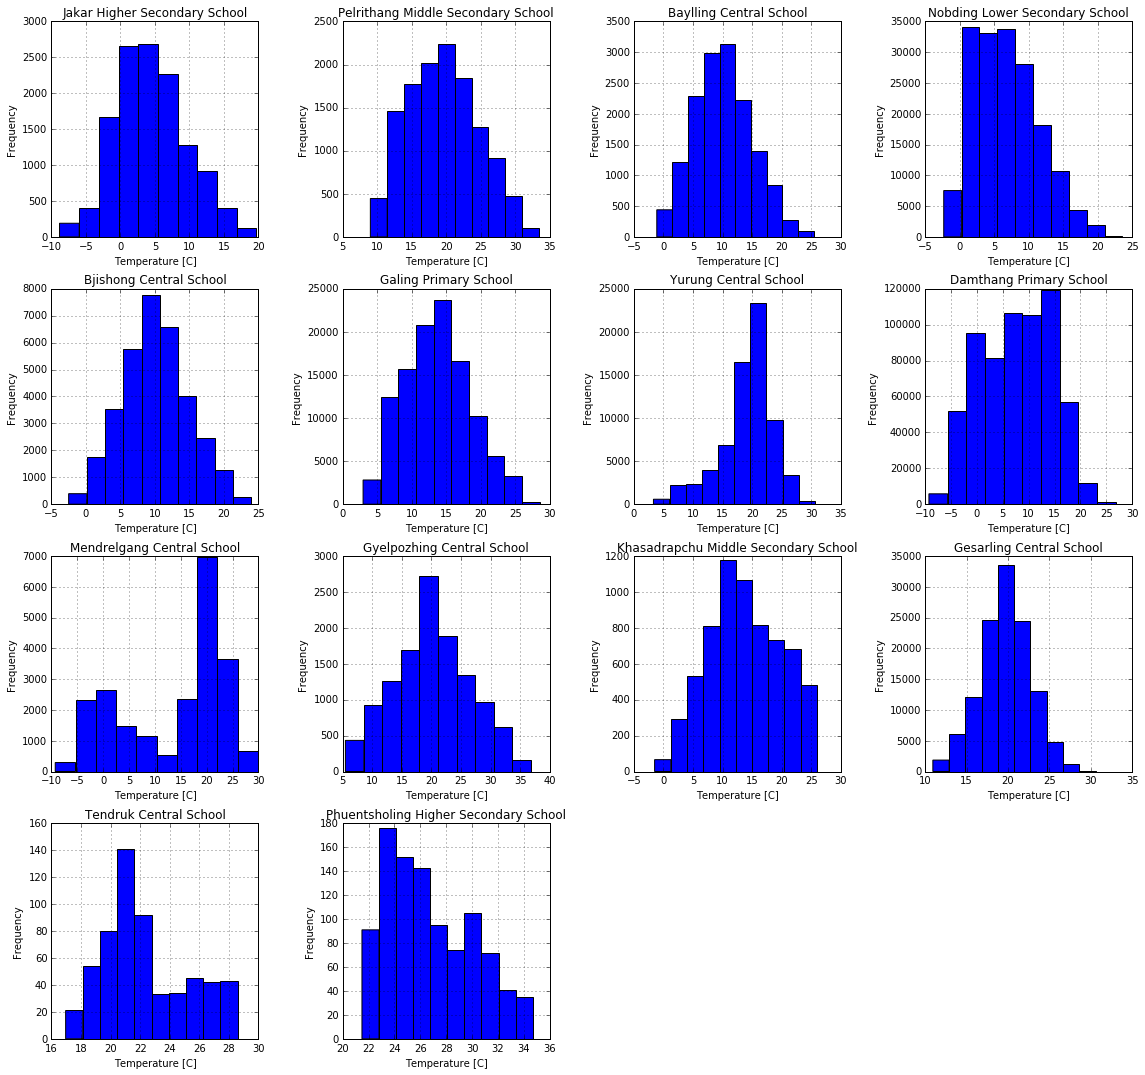

In [75]:
n_rows=4
n_cols=4
fig=plt.figure(figsize=(16,15))
for i, school in enumerate(dfc.school.unique()):
    ax=fig.add_subplot(n_rows,n_cols,i+1)
    dfc[dfc.school==school]['temp'].hist(ax=ax)
    ax.set_title(school)
    ax.set_xlabel('Temperature [C]')
    ax.set_ylabel('Frequency')
fig.tight_layout()
plt.show();

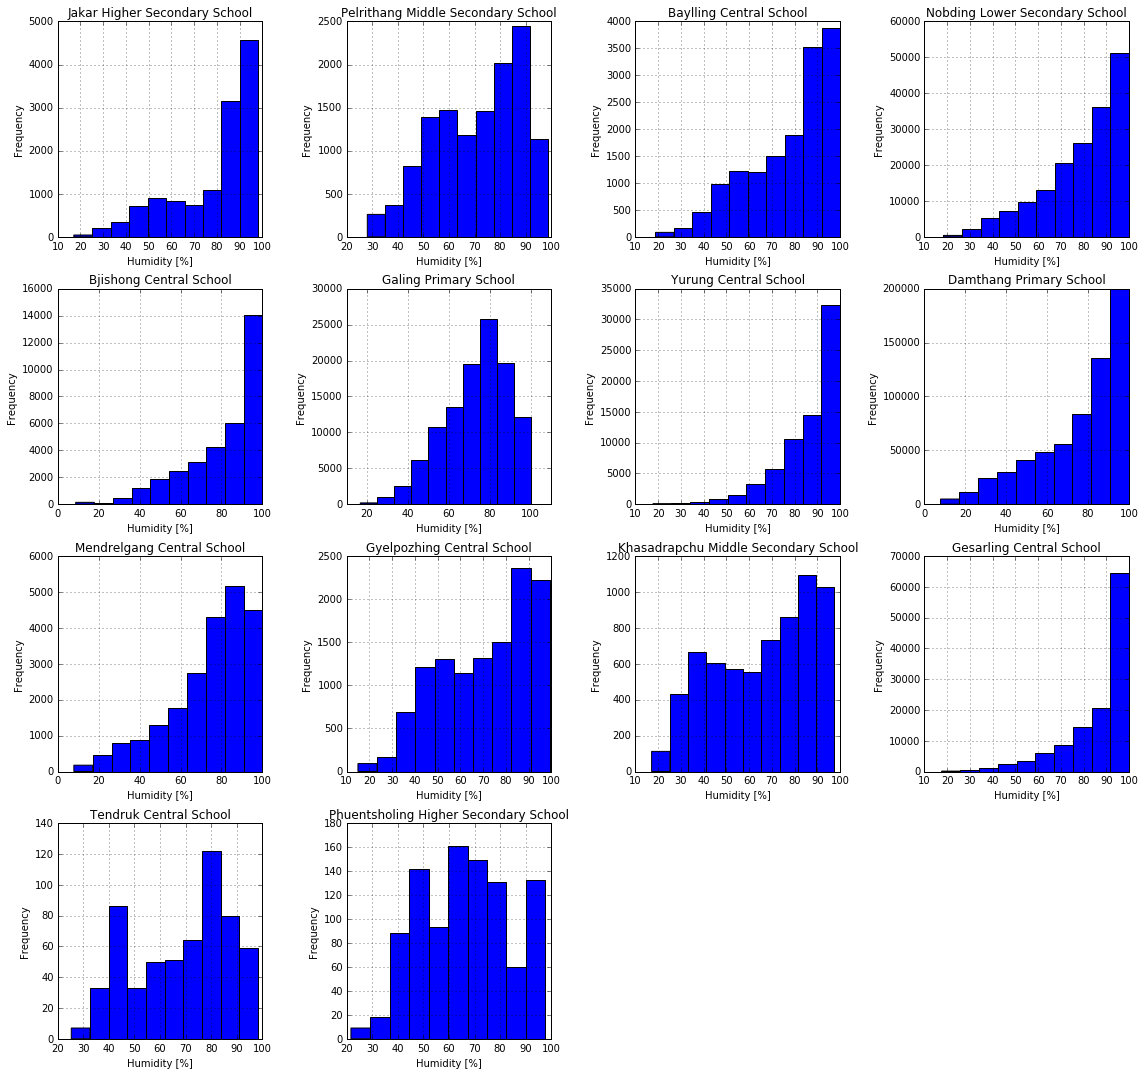

In [76]:
n_rows=4
n_cols=4
fig=plt.figure(figsize=(16,15))
for i, school in enumerate(dfc.school.unique()):
    ax=fig.add_subplot(n_rows,n_cols,i+1)
    dfc[dfc.school==school]['rh'].hist(ax=ax)
    ax.set_title(school)
    ax.set_xlabel('Humidity [%]')
    ax.set_ylabel('Frequency')
fig.tight_layout()
plt.show();

## Data export

In [79]:
file_out = '../data/processed/observations.csv'
dfo.to_csv(file_out, index=False, header=True)
print('%d records exported to %s' % (len(dfo), file_out))

623 records exported to ../data/processed/observations.csv


In [80]:
file_out = '../data/processed/climate.csv'
dfc.to_csv(file_out, index=False, header=True)
print('%d records exported to %s' % (len(dfc), file_out))

1226744 records exported to ../data/processed/climate.csv
